In [1]:
!pip install tslearn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.5 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from tslearn.metrics import cdist_dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Load and clean your data
df = pd.read_csv("/content/Amtrak_Ridership_Time_Series.csv")


# Normalize and compute DTW distance matrix
scaler = TimeSeriesScalerMeanVariance()
series_scaled = scaler.fit_transform(df.pivot(index='Year', columns='Station', values='Ridership'))
dtw_matrix = cdist_dtw(series_scaled)

# Create distance matrix DataFrame
dtw_df = pd.DataFrame(dtw_matrix, index=pivot_df.index, columns=pivot_df.index)


ValueError: Index contains duplicate entries, cannot reshape

In [3]:
df.head()

,Unnamed: 0,State,Station,Year,Ridership
0,10447,Maryland,"Aberdeen, Maryland",2005-01-01,23438.0
1,9847,Maryland,"Aberdeen, Maryland",2006-01-01,18008.0
2,9247,Maryland,"Aberdeen, Maryland",2007-01-01,38702.0
3,8647,Maryland,"Aberdeen, Maryland",2008-01-01,45052.0
4,8047,Maryland,"Aberdeen, Maryland",2009-01-01,44495.0


In [5]:
import pandas as pd
import numpy as np
from tslearn.metrics import cdist_dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Load your cleaned CSV
df_ts = pd.read_csv("Amtrak_Ridership_Time_Series.csv")

# Sum duplicates
df_ts_grouped = df_ts.groupby(['Station', 'Year'], as_index=False).agg({
    'State': 'first',
    'Ridership': 'sum'
})

# Pivot
pivot_df = df_ts_grouped.pivot(index='Station', columns='Year', values='Ridership').fillna(0)

# Convert to 3D format
series_array = pivot_df.to_numpy().reshape((pivot_df.shape[0], pivot_df.shape[1], 1))

# Normalize
scaler = TimeSeriesScalerMeanVariance()
series_scaled = scaler.fit_transform(series_array)

# Compute DTW matrix
dtw_matrix = cdist_dtw(series_scaled)

# Distance matrix
dtw_df = pd.DataFrame(dtw_matrix, index=pivot_df.index, columns=pivot_df.index)
dtw_df.to_csv("amtrak_dtw_matrix.csv")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [6]:
# Find top 5 most similar stations to "Lincoln, Nebraska"
target_station = "Lincoln, Nebraska"
similar_stations = dtw_df.loc[target_station].sort_values().iloc[1:6]
print(similar_stations)


Station
Oxnard, California         0.810410
Chatsworth, California     0.864194
Simi Valley, California    0.874446
Burbank, California        0.880921
Centralia, Washington      0.963146
Name: Lincoln, Nebraska, dtype: float64


<ipython-input-7-37653a88a408>:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(dtw_df, method='ward')


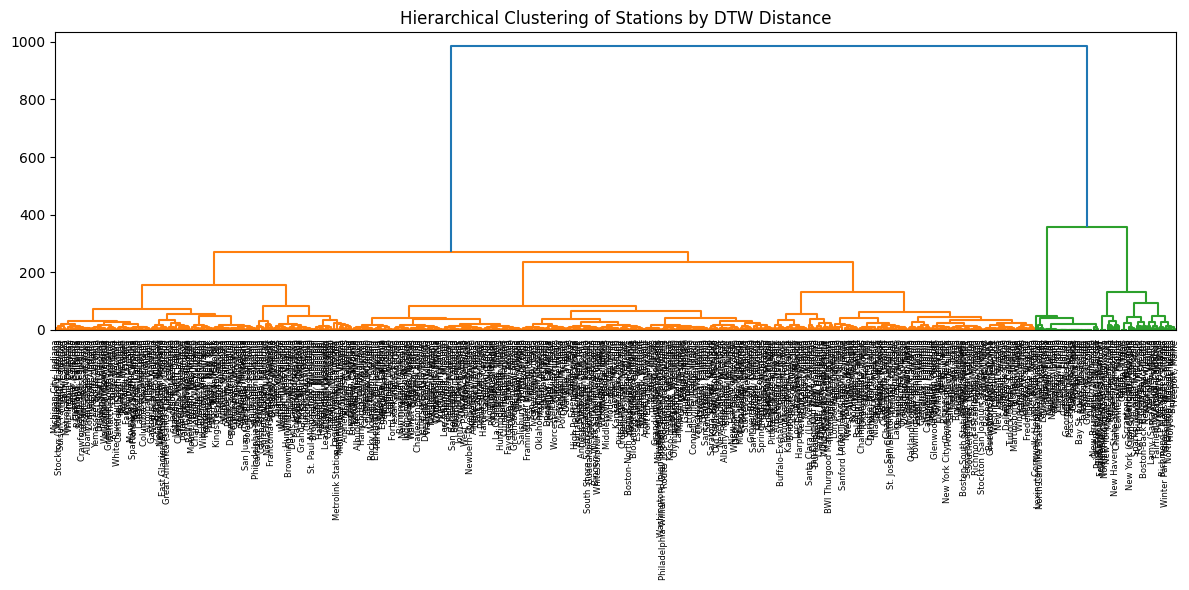

In [7]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

linked = linkage(dtw_df, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, labels=dtw_df.index, leaf_rotation=90, leaf_font_size=6)
plt.title("Hierarchical Clustering of Stations by DTW Distance")
plt.tight_layout()
plt.savefig("amtrak_dtw_dendrogram.png")
plt.show()


In [8]:
station1 = "Lincoln, Nebraska"
station2 = "Galesburg, Illinois"  # from top similar list

df_subset = df_ts[df_ts['Station'].isin([station1, station2])]
pivot_plot = df_subset.pivot(index='Year', columns='Station', values='Ridership')

pivot_plot.plot(title=f"Ridership Comparison: {station1} vs {station2}")



ValueError: Index contains duplicate entries, cannot reshape

<ipython-input-9-1cced4a35daa>:11: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(dtw_top, method='ward')


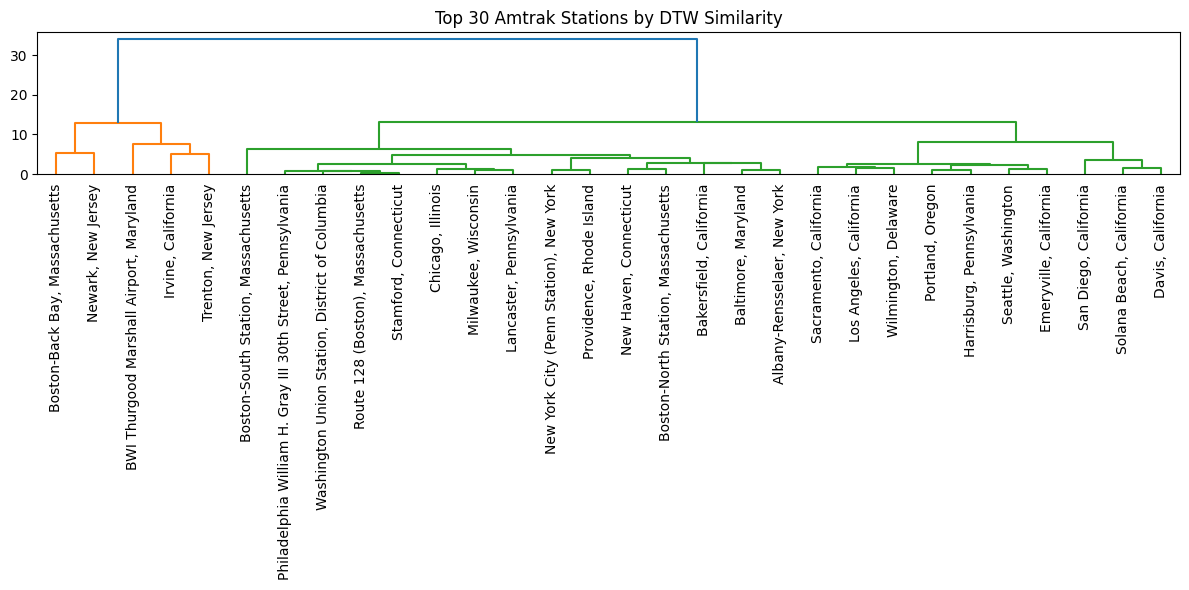

In [9]:
# Sum ridership per station
top_stations = df_ts.groupby("Station")["Ridership"].sum().sort_values(ascending=False).head(30).index

# Filter DTW matrix
dtw_top = dtw_df.loc[top_stations, top_stations]

# Redo clustering on top 30 stations
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

linked = linkage(dtw_top, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linked, labels=dtw_top.index, leaf_rotation=90)
plt.title("Top 30 Amtrak Stations by DTW Similarity")
plt.tight_layout()
plt.show()


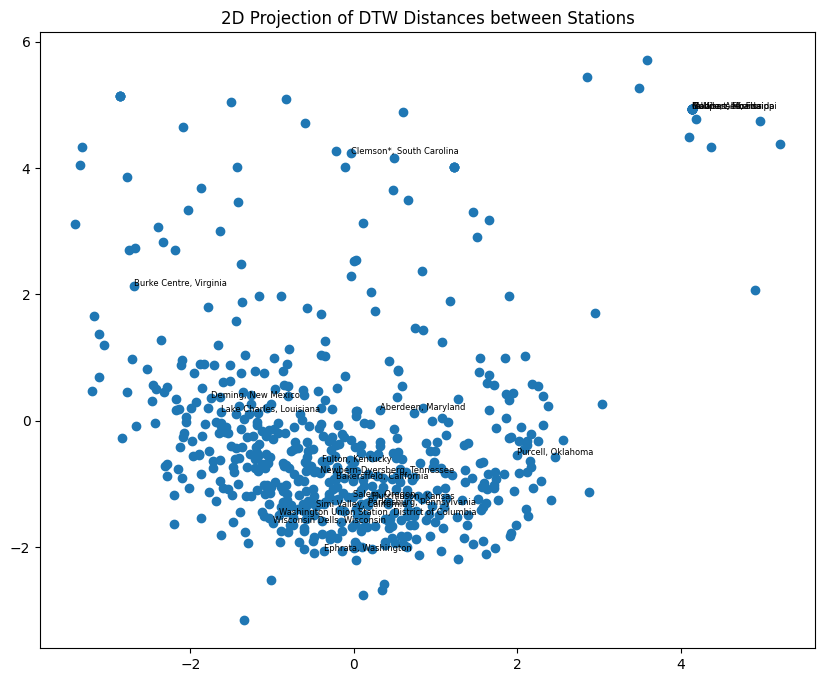

In [10]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(dtw_df)

plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1])
for i, station in enumerate(dtw_df.index):
    if i % 30 == 0:  # only label some for readability
        plt.text(coords[i, 0], coords[i, 1], station, fontsize=6)
plt.title("2D Projection of DTW Distances between Stations")
plt.show()


In [12]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=6, linkage='average')
dtw_df['Cluster'] = clustering.fit_predict(dtw_df)

# Now you can see which stations fall into each cluster
clustered = dtw_df[['Cluster']].sort_values('Cluster')
print(clustered.head(20))



Station                             Cluster
Station                                    
Arcadia, Missouri                         0
Sparks, Nevada (Train Stop)               0
Scranton, Pennsylvania                    0
Riverside, California                     0
Northampton, Massachusetts                0
Newark Airport, New Jersey                0
New York (Grand Central), New York        0
Ogden, Utah                               0
Napa, California                          0
Newark, New Jersey                        0
Fort Ticonderoga, New York                0
Greenfield, Massachusetts                 0
Meridian, Michigan                        0
Lamy (Santa Fe), New Mexico               0
Holyoke, Massachusetts                    0
Bend, Oregon                              0
Clemson*, South Carolina                  0
Coos Bay, Oregon                          0
Fairfield-Vacaville, California           0
Freeport, Maine                           0


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


<Axes: xlabel='Station'>

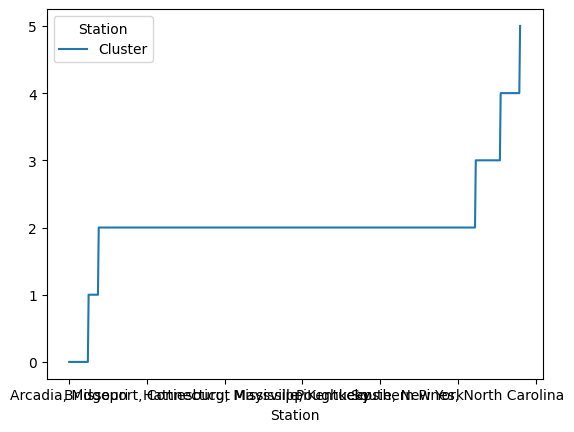

In [15]:
clustered.plot()

In [17]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=6,  linkage='average')
dtw_df['Cluster'] = clustering.fit_predict(dtw_df)

# Match cluster labels to MDS coordinates
coords_df = pd.DataFrame(coords, index=dtw_df.index, columns=['x', 'y'])
coords_df['Cluster'] = dtw_df['Cluster']


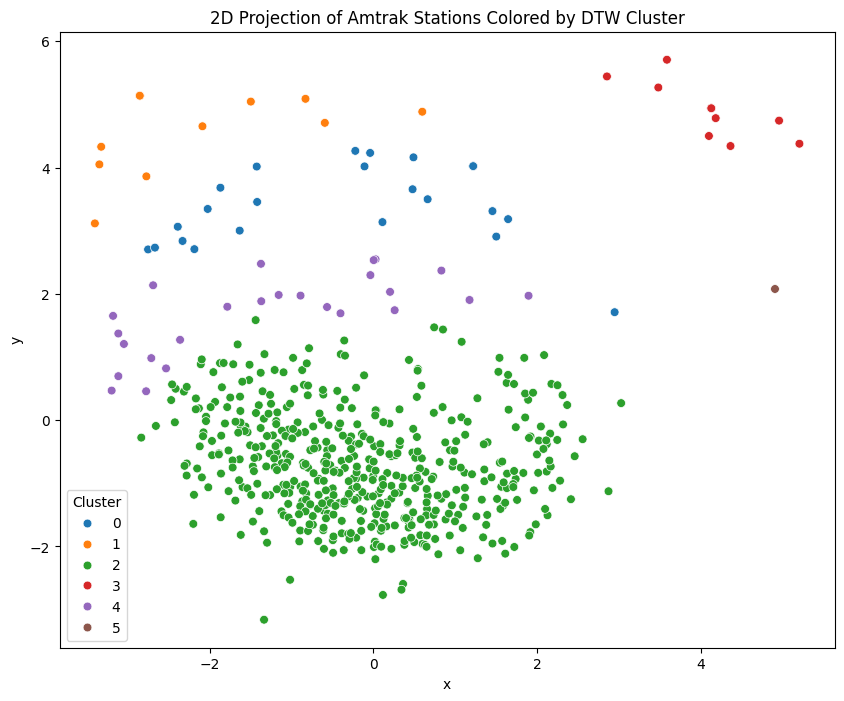

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.scatterplot(data=coords_df, x='x', y='y', hue='Cluster', palette='tab10', s=40)
plt.title("2D Projection of Amtrak Stations Colored by DTW Cluster")
plt.legend(title='Cluster')
plt.show()


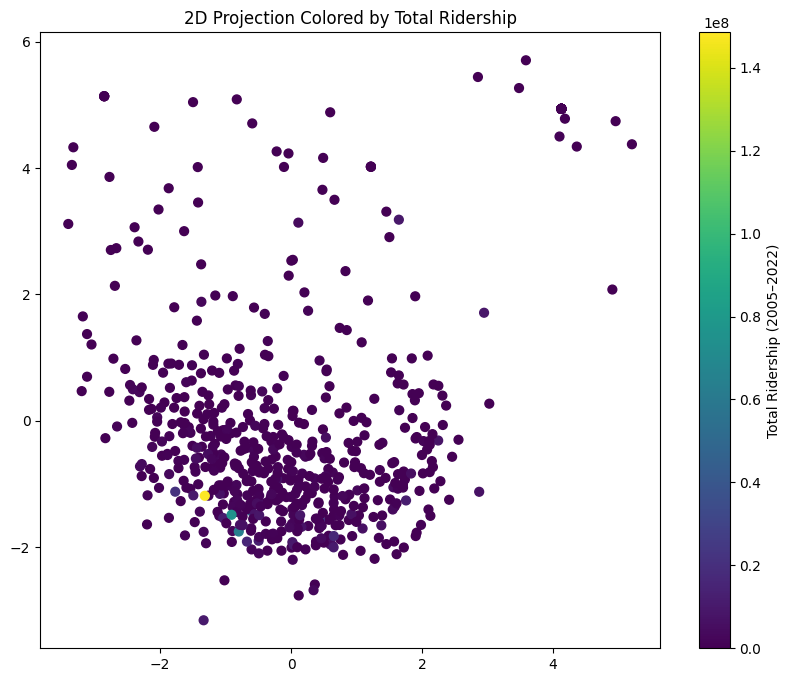

In [19]:
ridership_total = df_ts.groupby("Station")["Ridership"].sum()
coords_df['Total_Ridership'] = coords_df.index.map(ridership_total)

plt.figure(figsize=(10, 8))
plt.scatter(coords_df['x'], coords_df['y'], c=coords_df['Total_Ridership'], cmap='viridis', s=40)
plt.colorbar(label='Total Ridership (2005–2022)')
plt.title("2D Projection Colored by Total Ridership")
plt.show()


In [20]:
def dtw_over_time(station1, station2, pivot_df, window_size=5):
    years = pivot_df.columns
    distances = []
    window_labels = []

    for i in range(len(years) - window_size + 1):
        window = years[i:i+window_size]
        ts1 = pivot_df.loc[station1, window].fillna(0).to_numpy()
        ts2 = pivot_df.loc[station2, window].fillna(0).to_numpy()

        # reshape to (n_timestamps, 1)
        from tslearn.metrics import dtw
        dist = dtw(ts1.reshape(-1, 1), ts2.reshape(-1, 1))
        distances.append(dist)
        window_labels.append(f"{window[0].year}-{window[-1].year}")

    return pd.Series(distances, index=window_labels)


<Axes: title={'center': 'DTW Distance Over Time: Lincoln vs. Galesburg'}>

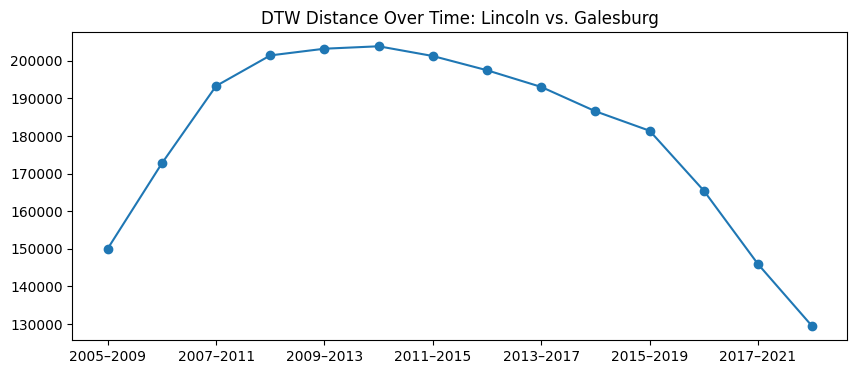

In [25]:
from tslearn.metrics import dtw
import pandas as pd

def dtw_over_time(station1, station2, pivot_df, window_size=5):
    years = pivot_df.columns
    distances = []
    window_labels = []

    for i in range(len(years) - window_size + 1):
        window = years[i:i+window_size]
        ts1 = pivot_df.loc[station1, window].fillna(0).to_numpy()
        ts2 = pivot_df.loc[station2, window].fillna(0).to_numpy()

        dist = dtw(ts1.reshape(-1, 1), ts2.reshape(-1, 1))
        distances.append(dist)

        # Just use string year range
        window_labels.append(f"{window[0][:4]}–{window[-1][:4]}")

    return pd.Series(distances, index=window_labels)
dtw_series = dtw_over_time("Lincoln, Nebraska", "Galesburg, Illinois", pivot_df)
dtw_series.plot(title="DTW Distance Over Time: Lincoln vs. Galesburg", marker='o', figsize=(10, 4))


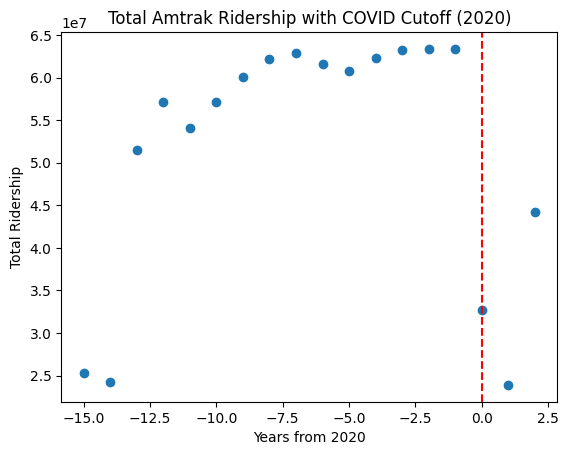

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=18 observations were given.
  return hypotest_fun_in(*args, **kwds)


                            OLS Regression Results                            
Dep. Variable:              ridership   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     10.64
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           0.000658
Time:                        19:05:36   Log-Likelihood:                -311.48
No. Observations:                  18   AIC:                             631.0
Df Residuals:                      14   BIC:                             634.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     7.275e+07   4.88e+06     14.904   

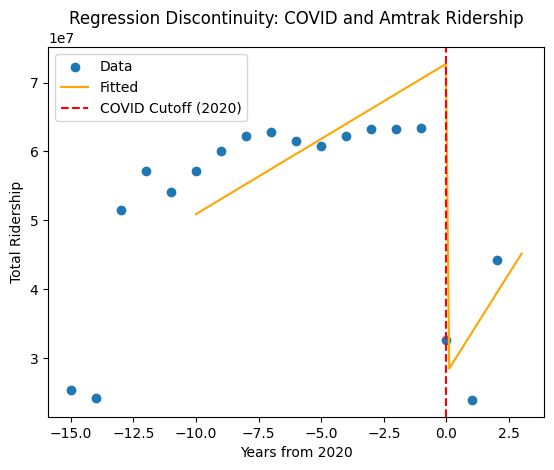

In [23]:

# Convert to datetime just to be sure
df_ts['Year'] = pd.to_datetime(df_ts['Year'])

# Aggregate by year or use month if available
annual_ridership = df_ts.groupby(df_ts['Year'].dt.year)['Ridership'].sum().reset_index()
annual_ridership.columns = ['year', 'ridership']

# Create running variable: centered year (0 = 2020, the cutoff)
annual_ridership['t'] = annual_ridership['year'] - 2020

import matplotlib.pyplot as plt

plt.scatter(annual_ridership['t'], annual_ridership['ridership'])
plt.axvline(0, color='red', linestyle='--')
plt.title("Total Amtrak Ridership with COVID Cutoff (2020)")
plt.xlabel("Years from 2020")
plt.ylabel("Total Ridership")
plt.show()

import statsmodels.formula.api as smf

# Create treatment indicator: 1 if t >= 0
annual_ridership['post_covid'] = (annual_ridership['t'] >= 0).astype(int)

# Local linear model with interaction
model = smf.ols("ridership ~ t + post_covid + t:post_covid", data=annual_ridership).fit()
print(model.summary())

import numpy as np

# Predicted values
t_range = np.linspace(-10, 3, 100)
df_pred = pd.DataFrame({
    't': t_range,
    'post_covid': (t_range >= 0).astype(int)
})
df_pred['t:post_covid'] = df_pred['t'] * df_pred['post_covid']
df_pred['pred'] = model.predict(df_pred)

# Plot
plt.scatter(annual_ridership['t'], annual_ridership['ridership'], label="Data")
plt.plot(t_range, df_pred['pred'], color='orange', label="Fitted")
plt.axvline(0, color='red', linestyle='--', label="COVID Cutoff (2020)")
plt.title("Regression Discontinuity: COVID and Amtrak Ridership")
plt.xlabel("Years from 2020")
plt.ylabel("Total Ridership")
plt.legend()
plt.show()


In [26]:
d = pd.read_csv("/content/Amtrak_Ridership_Time_Series.csv")

In [27]:
d.head()

,Unnamed: 0,State,Station,Year,Ridership
0,10447,Maryland,"Aberdeen, Maryland",2005-01-01,23438.0
1,9847,Maryland,"Aberdeen, Maryland",2006-01-01,18008.0
2,9247,Maryland,"Aberdeen, Maryland",2007-01-01,38702.0
3,8647,Maryland,"Aberdeen, Maryland",2008-01-01,45052.0
4,8047,Maryland,"Aberdeen, Maryland",2009-01-01,44495.0


In [28]:
d.drop(columns=['Unnamed: 0'], inplace=True)

In [29]:
d.to_csv("amtrak_ridership_time_series.csv", index=False)

In [31]:
import pandas as pd

# Reload the full Amtrak time series dataset
df_ts = pd.read_csv("Amtrak_Ridership_Time_Series.csv")
df_ts['Year'] = pd.to_datetime(df_ts['Year'])

# Get the latest station and state mapping
station_state = df_ts.drop_duplicates(subset="Station")[["Station", "State"]]

# Aggregate total ridership by station
station_totals = df_ts.groupby("Station")["Ridership"].sum().reset_index()

# Merge state information back into station totals
station_totals = station_totals.merge(station_state, on="Station", how="left")

# Define U.S. census regions manually
region_def = {
    "Northeast": [
        "Connecticut", "Maine", "Massachusetts", "New Hampshire",
        "Rhode Island", "Vermont", "New Jersey", "New York", "Pennsylvania"
    ],
    "Midwest": [
        "Indiana", "Illinois", "Michigan", "Ohio", "Wisconsin",
        "Iowa", "Kansas", "Minnesota", "Missouri", "Nebraska", "North Dakota", "South Dakota"
    ],
    "South": [
        "Delaware", "Florida", "Georgia", "Maryland", "North Carolina",
        "South Carolina", "Virginia", "West Virginia", "Alabama", "Kentucky",
        "Mississippi", "Tennessee", "Arkansas", "Louisiana", "Oklahoma", "Texas", "District of Columbia"
    ],
    "West": [
        "Arizona", "Colorado", "Idaho", "Montana", "Nevada", "New Mexico", "Utah", "Wyoming",
        "Alaska", "California", "Hawaii", "Oregon", "Washington"
    ]
}

# Assign region to each station
def assign_region(state):
    for region, states in region_def.items():
        if state in states:
            return region
    return "Other"

station_totals["Region"] = station_totals["State"].apply(assign_region)

# Get top 10 stations by volume per region
top_stations_by_region = (
    station_totals.groupby("Region", group_keys=False)
    .apply(lambda x: x.nlargest(10, "Ridership"))
    .reset_index(drop=True)
)





<ipython-input-31-3b3960f1be54>:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(10, "Ridership"))


In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Define regions and assign data for plotting (you must precompute these)
regions = ["Northeast", "Midwest", "South", "West"]
region_data = {
    "Northeast": df_northeast,  # these should include columns: t, total_ridership, pred
    "Midwest": df_midwest,
    "South": df_south,
    "West": df_west
}

fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, region in enumerate(regions):
    ax = axs[i]
    df = region_data[region]

    # Plot actual data
    ax.plot(df['t'], df['total_ridership'], 'o', markersize=4, color='black', label=None)

    # Plot fitted line
    ax.plot(df['t'], df['pred'], '-', color='black', linewidth=1)

    # COVID cutoff
    ax.axvline(0, linestyle='--', color='gray', linewidth=0.8)

    # Style adjustments
    ax.set_title(region, fontsize=10, fontname='serif')
    ax.tick_params(axis='both', which='both', length=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('outward', 5))
    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_bounds(df['total_ridership'].min(), df['total_ridership'].max())
    ax.spines['bottom'].set_bounds(df['t'].min(), df['t'].max())
    ax.set_xticks(np.arange(df['t'].min(), df['t'].max()+1, 2))
    ax.set_yticks([])

# Global layout
fig.suptitle("Regression Discontinuity by Region", fontsize=12, fontname='serif')
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig("amtrak_rdd_subplots.png", dpi=300)
plt.show()


NameError: name 'df_northeast' is not defined

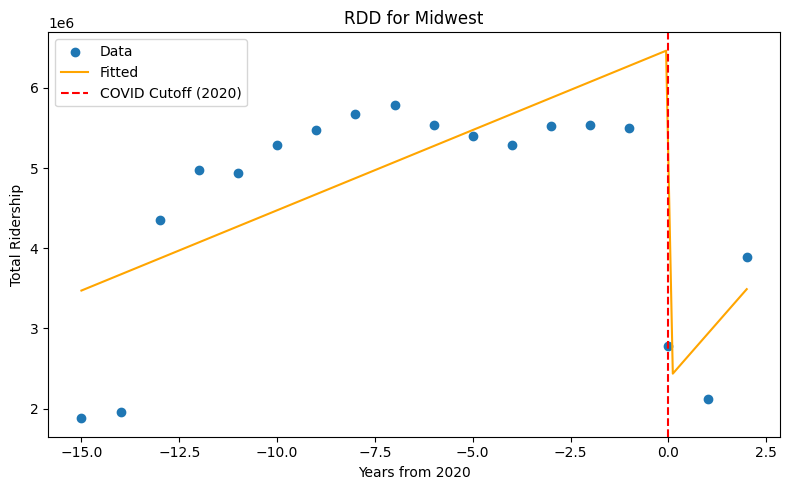


=== RDD Summary for Midwest ===
                            OLS Regression Results                            
Dep. Variable:              ridership   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     8.508
Date:                Sat, 19 Apr 2025   Prob (F-statistic):            0.00183
Time:                        19:49:04   Log-Likelihood:                -270.32
No. Observations:                  18   AIC:                             548.6
Df Residuals:                      14   BIC:                             552.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=18 observations were given.
  return hypotest_fun_in(*args, **kwds)


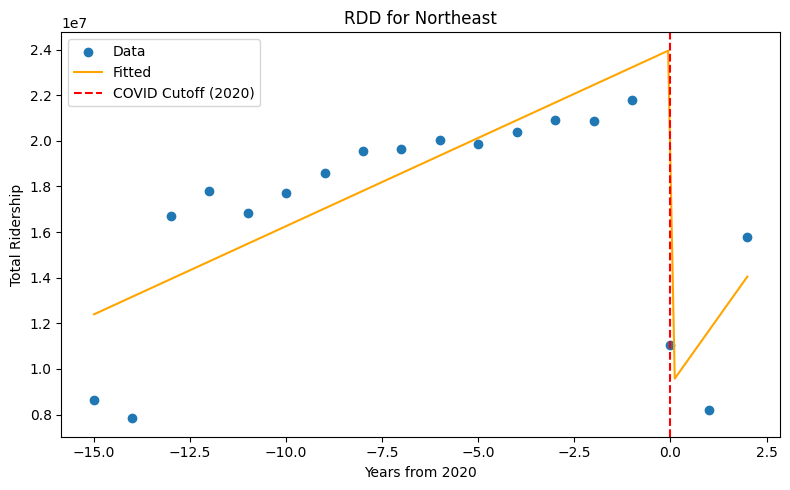


=== RDD Summary for Northeast ===
                            OLS Regression Results                            
Dep. Variable:              ridership   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     13.56
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           0.000200
Time:                        19:49:04   Log-Likelihood:                -289.08
No. Observations:                  18   AIC:                             586.2
Df Residuals:                      14   BIC:                             589.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=18 observations were given.
  return hypotest_fun_in(*args, **kwds)


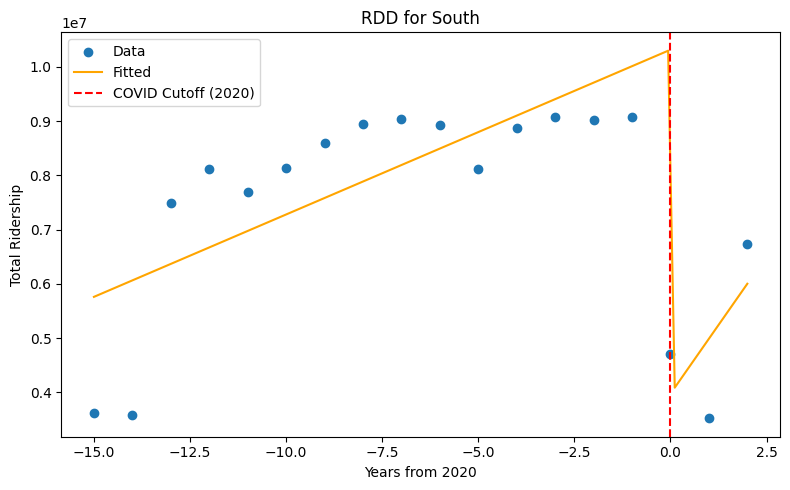


=== RDD Summary for South ===
                            OLS Regression Results                            
Dep. Variable:              ridership   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     9.647
Date:                Sat, 19 Apr 2025   Prob (F-statistic):            0.00104
Time:                        19:49:05   Log-Likelihood:                -276.68
No. Observations:                  18   AIC:                             561.4
Df Residuals:                      14   BIC:                             564.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.0

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=18 observations were given.
  return hypotest_fun_in(*args, **kwds)


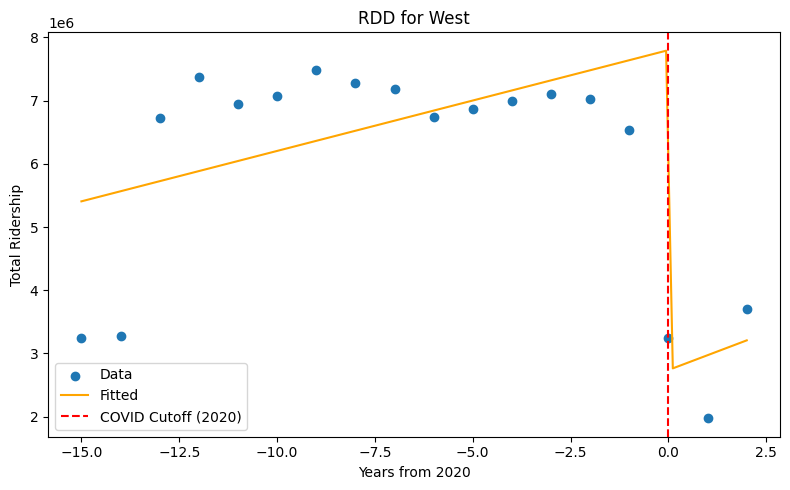


=== RDD Summary for West ===
                            OLS Regression Results                            
Dep. Variable:              ridership   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     9.133
Date:                Sat, 19 Apr 2025   Prob (F-statistic):            0.00133
Time:                        19:49:05   Log-Likelihood:                -275.08
No. Observations:                  18   AIC:                             558.2
Df Residuals:                      14   BIC:                             561.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       7.

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=18 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [33]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np

# Prepare a function to run RDD and plot results
def run_rdd_for_dynamic_region(region_name, stations, df_ts):
    subset = df_ts[df_ts["Station"].isin(stations)]
    annual = subset.groupby(subset["Year"].dt.year)["Ridership"].sum().reset_index()
    annual.columns = ["year", "ridership"]
    annual['t'] = annual['year'] - 2020
    annual['post_covid'] = (annual['t'] >= 0).astype(int)

    model = smf.ols("ridership ~ t + post_covid + t:post_covid", data=annual).fit()

    # Prediction
    t_range = np.linspace(annual['t'].min(), annual['t'].max(), 100)
    df_pred = pd.DataFrame({
        't': t_range,
        'post_covid': (t_range >= 0).astype(int)
    })
    df_pred['t:post_covid'] = df_pred['t'] * df_pred['post_covid']
    df_pred['pred'] = model.predict(df_pred)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(annual['t'], annual['ridership'], label="Data")
    plt.plot(df_pred['t'], df_pred['pred'], color='orange', label="Fitted")
    plt.axvline(0, color='red', linestyle='--', label="COVID Cutoff (2020)")
    plt.title(f"RDD for {region_name}")
    plt.xlabel("Years from 2020")
    plt.ylabel("Total Ridership")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"\n=== RDD Summary for {region_name} ===")
    print(model.summary())

# Loop over each region using the dynamic top-10 stations
for region in top_stations_by_region['Region'].unique():
    region_stations = top_stations_by_region[top_stations_by_region['Region'] == region]['Station'].tolist()
    run_rdd_for_dynamic_region(region, region_stations, df_ts)


In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Define regions and assign data for plotting (you must precompute these)
regions = ["Northeast", "Midwest", "South", "West"]
region_data = {
    "Northeast": df_northeast,  # these should include columns: t, total_ridership, pred
    "Midwest": df_midwest,
    "South": df_south,
    "West": df_west
}

fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, region in enumerate(regions):
    ax = axs[i]
    df = region_data[region]

    # Plot actual data
    ax.plot(df['t'], df['total_ridership'], 'o', markersize=4, color='black', label=None)

    # Plot fitted line
    ax.plot(df['t'], df['pred'], '-', color='black', linewidth=1)

    # COVID cutoff
    ax.axvline(0, linestyle='--', color='gray', linewidth=0.8)

    # Style adjustments
    ax.set_title(region, fontsize=10, fontname='serif')
    ax.tick_params(axis='both', which='both', length=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('outward', 5))
    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_bounds(df['total_ridership'].min(), df['total_ridership'].max())
    ax.spines['bottom'].set_bounds(df['t'].min(), df['t'].max())
    ax.set_xticks(np.arange(df['t'].min(), df['t'].max()+1, 2))
    ax.set_yticks([])

# Global layout
fig.suptitle("Regression Discontinuity by Region", fontsize=12, fontname='serif')
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig("amtrak_rdd_subplots.png", dpi=300)
plt.show()


NameError: name 'df_northeast' is not defined

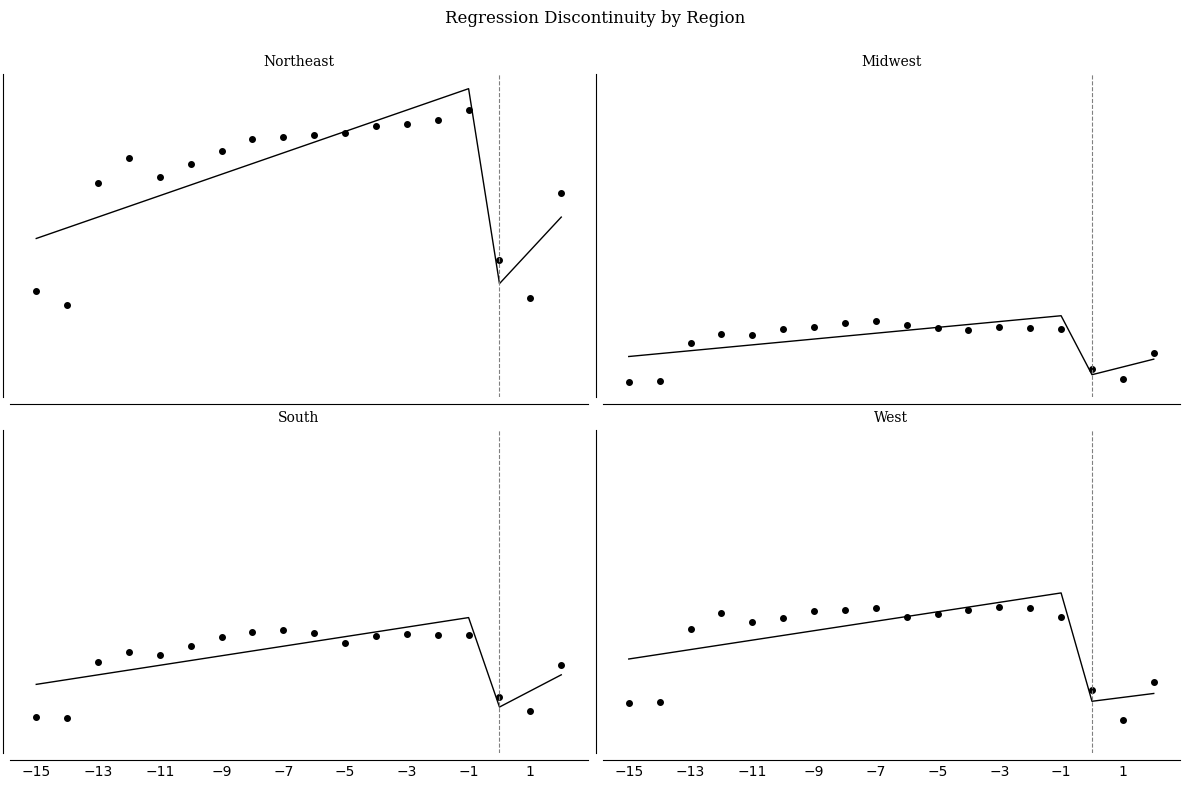

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Load and preprocess the data
df_ts = pd.read_csv("Amtrak_Ridership_Time_Series.csv")
df_ts['Year'] = pd.to_datetime(df_ts['Year'])

# Assign regions using state
region_def = {
    "Northeast": [
        "Connecticut", "Maine", "Massachusetts", "New Hampshire",
        "Rhode Island", "Vermont", "New Jersey", "New York", "Pennsylvania"
    ],
    "Midwest": [
        "Indiana", "Illinois", "Michigan", "Ohio", "Wisconsin",
        "Iowa", "Kansas", "Minnesota", "Missouri", "Nebraska", "North Dakota", "South Dakota"
    ],
    "South": [
        "Delaware", "Florida", "Georgia", "Maryland", "North Carolina",
        "South Carolina", "Virginia", "West Virginia", "Alabama", "Kentucky",
        "Mississippi", "Tennessee", "Arkansas", "Louisiana", "Oklahoma", "Texas", "District of Columbia"
    ],
    "West": [
        "Arizona", "Colorado", "Idaho", "Montana", "Nevada", "New Mexico", "Utah", "Wyoming",
        "Alaska", "California", "Hawaii", "Oregon", "Washington"
    ]
}

def assign_region(state):
    for region, states in region_def.items():
        if state in states:
            return region
    return "Other"

station_state = df_ts.drop_duplicates(subset="Station")[["Station", "State"]]
station_state["Region"] = station_state["State"].apply(assign_region)
df_ts = df_ts.merge(station_state[["Station", "Region"]], on="Station", how="left")

# Prepare region-wise predictions
region_models = {}
region_predictions = {}

for region in ["Northeast", "Midwest", "South", "West"]:
    subset = df_ts[df_ts["Region"] == region].copy()
    subset['year'] = subset["Year"].dt.year
    annual = subset.groupby("year")["Ridership"].sum().reset_index()
    annual["t"] = annual["year"] - 2020
    annual["post_covid"] = (annual["t"] >= 0).astype(int)
    annual["t_post"] = annual["t"] * annual["post_covid"]

    model = smf.ols("Ridership ~ t + post_covid + t_post", data=annual).fit()
    region_models[region] = model

    # Predict over the same t range
    t_range = np.arange(annual["t"].min(), annual["t"].max() + 1)
    df_pred = pd.DataFrame({
        "t": t_range,
        "post_covid": (t_range >= 0).astype(int)
    })
    df_pred["t_post"] = df_pred["t"] * df_pred["post_covid"]
    df_pred["pred"] = model.predict(df_pred)
    df_pred["t"] = t_range
    df_pred["region"] = region

    # Merge observed for scatter plot
    merged = pd.merge(df_pred, annual[["t", "Ridership"]], on="t", how="left")
    region_predictions[region] = merged

# Plot minimalist 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, region in enumerate(["Northeast", "Midwest", "South", "West"]):
    df = region_predictions[region]
    ax = axs[i]

    # Plot actual data
    ax.plot(df['t'], df['Ridership'], 'o', markersize=4, color='black')

    # Plot fitted line
    ax.plot(df['t'], df['pred'], '-', color='black', linewidth=1)

    # COVID cutoff
    ax.axvline(0, linestyle='--', color='gray', linewidth=0.8)

    # Minimalist styling
    ax.set_title(region, fontsize=10, fontname='serif')
    ax.tick_params(axis='both', which='both', length=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('outward', 5))
    ax.spines['bottom'].set_position(('outward', 5))
    ax.set_yticks([])
    ax.set_xticks(np.arange(df['t'].min(), df['t'].max()+1, 2))

fig.suptitle("Regression Discontinuity by Region", fontsize=12, fontname='serif')
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig("amtrak_rdd_subplots.png", dpi=300)
plt.show()


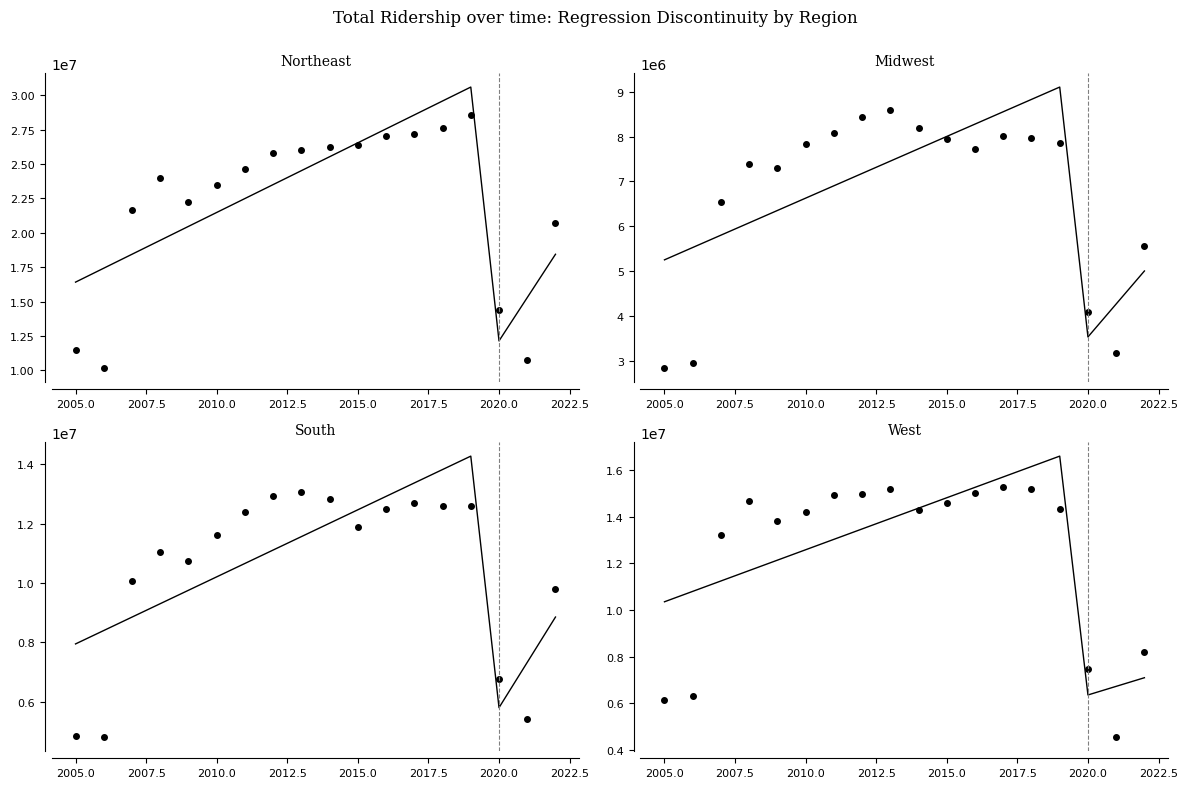

In [38]:
# Update subplot code to use date on x-axis and show y-axis values

fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=False)
axs = axs.flatten()

for i, region in enumerate(["Northeast", "Midwest", "South", "West"]):
    df = region_predictions[region].copy()
    ax = axs[i]

    # Recover actual year from t
    df["year"] = df["t"] + 2020

    # Plot actual data
    ax.plot(df["year"], df["Ridership"], 'o', markersize=4, color='black')

    # Plot fitted line
    ax.plot(df["year"], df["pred"], '-', color='black', linewidth=1)

    # COVID cutoff
    ax.axvline(2020, linestyle='--', color='gray', linewidth=0.8)

    # Minimalist styling with y-axis shown
    ax.set_title(region, fontsize=10, fontname='serif')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('outward', 5))
    ax.spines['bottom'].set_position(('outward', 5))
    ax.tick_params(axis='x', which='both', labelsize=8)
    ax.tick_params(axis='y', which='both', labelsize=8)

fig.suptitle("Total Ridership over time: Regression Discontinuity by Region", fontsize=12, fontname='serif')
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig("amtrak_rdd_subplots_with_dates.png", dpi=300)
plt.show()


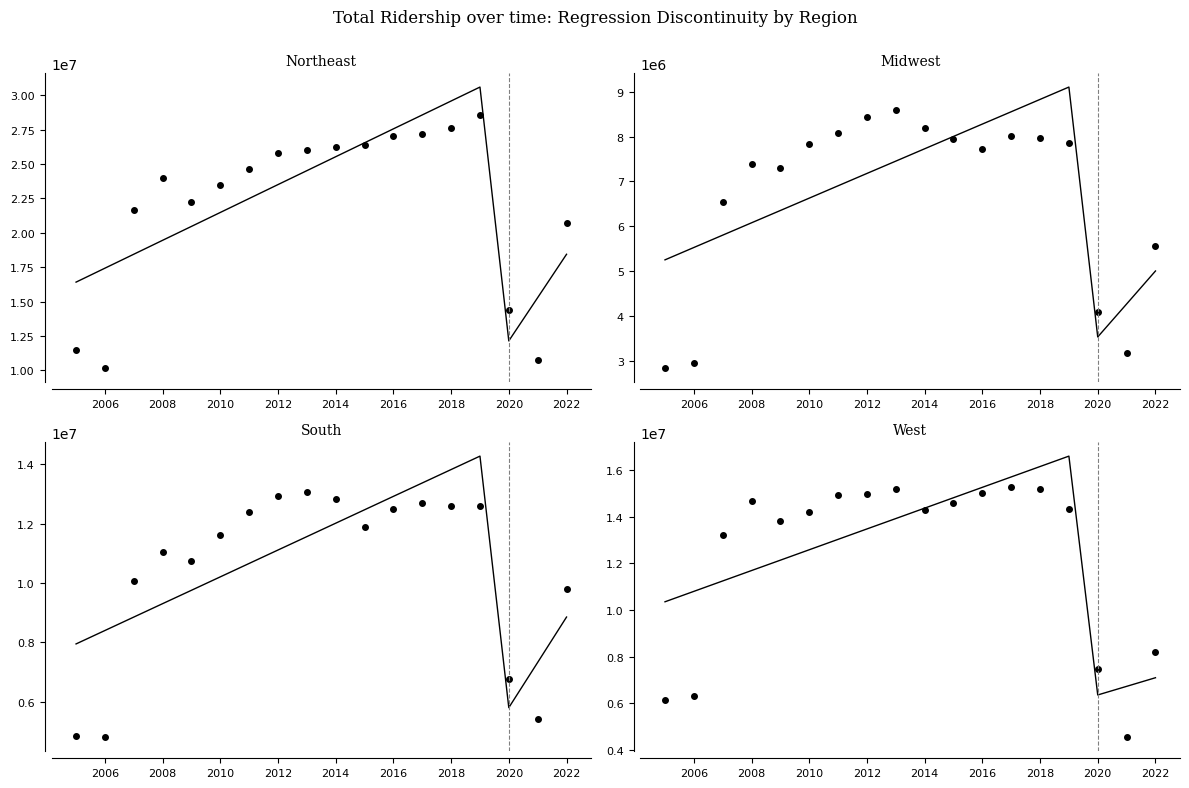

In [40]:
# Update x-axis to use datetime objects for clean year formatting
import matplotlib.dates as mdates

fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=False)
axs = axs.flatten()

for i, region in enumerate(["Northeast", "Midwest", "South", "West"]):
    df = region_predictions[region].copy()
    ax = axs[i]

    # Recover actual year from t
    df["year"] = pd.to_datetime(df["t"] + 2020, format="%Y")

    # Plot actual data
    ax.plot(df["year"], df["Ridership"], 'o', markersize=4, color='black')

    # Plot fitted line
    ax.plot(df["year"], df["pred"], '-', color='black', linewidth=1)

    # COVID cutoff
    ax.axvline(pd.to_datetime("2020-01-01"), linestyle='--', color='gray', linewidth=0.8)

    # Minimalist styling with y-axis shown
    ax.set_title(region, fontsize=10, fontname='serif')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('outward', 5))
    ax.spines['bottom'].set_position(('outward', 5))
    ax.tick_params(axis='x', which='both', labelsize=8)
    ax.tick_params(axis='y', which='both', labelsize=8)

    # Format x-axis as years
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.suptitle("Total Ridership over time: Regression Discontinuity by Region", fontsize=12, fontname='serif')
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig("amtrak_rdd_subplots_yearaxis.png", dpi=300)
plt.show()


In [3]:
import pandas as pd
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

# Load and prepare data
df = pd.read_csv("Amtrak_Ridership_Time_Series.csv")
df['Year'] = pd.to_datetime(df['Year'])
df['year'] = df['Year'].dt.year
df['post_covid'] = (df['year'] >= 2020).astype(int)

# Clean ridership
df['Ridership'] = pd.to_numeric(df['Ridership'], errors='coerce')
df = df.dropna(subset=['Ridership'])

# Set up panel structure
df = df.set_index(['Station', 'year']).sort_index()

# Add time trend (optional)
df['t'] = df.index.get_level_values('year') - 2005

# Prepare model data
df['const'] = 1

# Fixed effects model
mod = PanelOLS.from_formula(
    'Ridership ~ post_covid + t + EntityEffects',
    data=df
)
res = mod.fit(cov_type='clustered', cluster_entity=True)

print(res.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:              Ridership   R-squared:                        0.0288
Estimator:                   PanelOLS   R-squared (Between):              0.0171
No. Observations:                9244   R-squared (Within):               0.0288
Date:                Sun, Apr 20 2025   R-squared (Overall):              0.0179
Time:                        01:29:27   Log-likelihood                -1.222e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      128.36
Entities:                         581   P-value                           0.0000
Avg Obs:                       15.910   Distribution:                  F(2,8661)
Min Obs:                       1.0000                                           
Max Obs:                       19.000   F-statistic (robust):             17.256
                            

In [2]:
!pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.3 MB/s eta 0:00:00


In [4]:

df['region'] = station_state.set_index("Station").loc[df.index.get_level_values('Station')]['Region'].values

mod = PanelOLS.from_formula("Ridership ~ post_covid * region + t + EntityEffects", data=df)
res = mod.fit(cov_type='clustered', cluster_entity=True)

print(res.summary)
mod = PanelOLS.from_formula("Ridership ~ post_covid + EntityEffects + TimeEffects", data=df)
res = mod.fit(cov_type='clustered', cluster_entity=True)

print(res.summary)


NameError: name 'station_state' is not defined

In [5]:
df.head()

Unnamed: 0     State       Year  Ridership  \
Station            year                                               
Aberdeen, Maryland 2005       10447  Maryland 2005-01-01    23438.0   
                   2006        9847  Maryland 2006-01-01    18008.0   
                   2007        9247  Maryland 2007-01-01    38702.0   
                   2008        8647  Maryland 2008-01-01    45052.0   
                   2009        8047  Maryland 2009-01-01    44495.0   

                         post_covid  t  const  
Station            year                        
Aberdeen, Maryland 2005           0  0      1  
                   2006           0  1      1  
                   2007           0  2      1  
                   2008           0  3      1  
                   2009           0  4      1

In [7]:
# Re-import necessary libraries after code environment reset
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

# Load and prepare the Amtrak data
df_ts = pd.read_csv("Amtrak_Ridership_Time_Series.csv")
df_ts['Year'] = pd.to_datetime(df_ts['Year'])
df_ts['year'] = df_ts['Year'].dt.year
df_ts['post_covid'] = (df_ts['year'] >= 2020).astype(int)
df_ts['Ridership'] = pd.to_numeric(df_ts['Ridership'], errors='coerce')
df_ts = df_ts.dropna(subset=['Ridership'])

# Region assignment
region_def = {
    "Northeast": ["Connecticut", "Maine", "Massachusetts", "New Hampshire", "Rhode Island", "Vermont", "New Jersey", "New York", "Pennsylvania"],
    "Midwest": ["Indiana", "Illinois", "Michigan", "Ohio", "Wisconsin", "Iowa", "Kansas", "Minnesota", "Missouri", "Nebraska", "North Dakota", "South Dakota"],
    "South": ["Delaware", "Florida", "Georgia", "Maryland", "North Carolina", "South Carolina", "Virginia", "West Virginia", "Alabama", "Kentucky", "Mississippi", "Tennessee", "Arkansas", "Louisiana", "Oklahoma", "Texas", "District of Columbia"],
    "West": ["Arizona", "Colorado", "Idaho", "Montana", "Nevada", "New Mexico", "Utah", "Wyoming", "Alaska", "California", "Hawaii", "Oregon", "Washington"]
}

def assign_region(state):
    for region, states in region_def.items():
        if state in states:
            return region
    return "Other"

station_state = df_ts.drop_duplicates(subset="Station")[["Station", "State"]].copy()
station_state["Region"] = station_state["State"].apply(assign_region)

# Merge region into main dataset
df_ts = df_ts.merge(station_state[["Station", "Region"]], on="Station", how="left")

# Prepare panel structure
df_ts = df_ts.set_index(['Station', 'year']).sort_index()
df_ts['t'] = df_ts.index.get_level_values('year') - 2005
df_ts['region'] = df_ts['Region']
df_ts['const'] = 1

# Model 1: Region × Post-COVID interaction
mod1 = PanelOLS.from_formula("Ridership ~ post_covid * region + t + EntityEffects", data=df_ts)
res1 = mod1.fit(cov_type='clustered', cluster_entity=True)

# Model 2: Add Time Fixed Effects
mod2 = PanelOLS.from_formula("Ridership ~ post_covid + EntityEffects + TimeEffects", data=df_ts)
res2 = mod2.fit(cov_type='clustered', cluster_entity=True)

res1.summary, res2.summary


AbsorbingEffectError: 
The model cannot be estimated. The included effects have fully absorbed
one or more of the variables. This occurs when one or more of the dependent
variable is perfectly explained using the effects included in the model.

The following variables or variable combinations have been fully absorbed
or have become perfectly collinear after effects are removed:

          post_covid, region[Midwest], region[Northeast], region[South], region[West]
          post_covid, region[Midwest], region[Northeast], region[South], region[West], post_covid:region[T.Northeast], post_covid:region[T.South], post_covid:region[T.West]
          post_covid, region[Midwest], region[Northeast], region[South], region[West], t, post_covid:region[T.Northeast], post_covid:region[T.South]

Set drop_absorbed=True to automatically drop absorbed variables.


In [8]:
mod1 = PanelOLS.from_formula(
    "Ridership ~ post_covid * region + t + EntityEffects",
    data=df_ts,
    drop_absorbed=True
)
res1 = mod1.fit(cov_type='clustered', cluster_entity=True)


<ipython-input-8-d28dc54a0a02>:6: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

region[Northeast], region[South], region[West]

  res1 = mod1.fit(cov_type='clustered', cluster_entity=True)


In [10]:
res1.summary

Dep. Variable:,Ridership,R-squared:,0.0325
Estimator:,PanelOLS,R-squared (Between):,-0.1367
No. Observations:,9244,R-squared (Within):,0.0325
Date:,"Sun, Apr 20 2025",R-squared (Overall):,-0.1155
Time:,01:34:15,Log-likelihood,-1.222e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,58.105
Entities:,581,P-value,0.0000
Avg Obs:,15.910,Distribution:,"F(5,8658)"
Min Obs:,1.0000,,
Max Obs:,19.000,F-statistic (robust):,2.342e+04


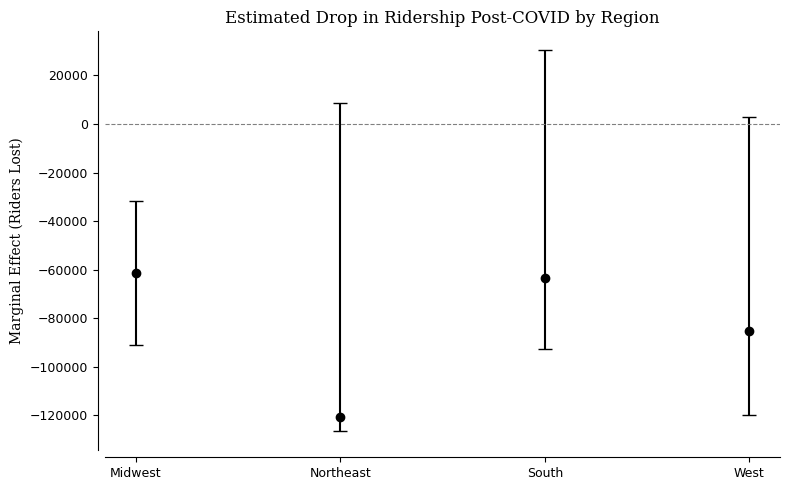

In [11]:
import matplotlib.pyplot as plt

# Manually extract coefficients and confidence intervals from the summary
effects = {
    'Midwest': -61450,
    'Northeast': -61450 - 59010,
    'South': -61450 - 1998,
    'West': -61450 - 23890
}

# Confidence intervals
ci = {
    'Midwest': ( -91030, -31870),
    'Northeast': (-126500, 8500),
    'South': (-34260, 30260),
    'West': (-50800, 3030)
}

regions = list(effects.keys())
coefs = [effects[r] for r in regions]
errors = [(abs(ci[r][0] - coefs[i]), abs(ci[r][1] - coefs[i])) for i, r in enumerate(regions)]
lower_err = [e[0] for e in errors]
upper_err = [e[1] for e in errors]

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

ax.errorbar(regions, coefs, yerr=[lower_err, upper_err], fmt='o', color='black', capsize=5)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)

# Minimalist styling
ax.set_title("Estimated Drop in Ridership Post-COVID by Region", fontname='serif')
ax.set_ylabel("Marginal Effect (Riders Lost)", fontname='serif')
ax.tick_params(axis='x', labelsize=9)
ax.tick_params(axis='y', labelsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))

plt.tight_layout()
plt.savefig("amtrak_panel_region_effects.png", dpi=300)
plt.show()


<ipython-input-14-c39c9cba16ce>:48: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

region[Northeast], region[South], region[West]

  res = model.fit(cov_type="clustered", cluster_entity=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:              Ridership   R-squared:                        0.0325
Estimator:                   PanelOLS   R-squared (Between):             -0.1367
No. Observations:                9244   R-squared (Within):               0.0325
Date:                Sun, Apr 20 2025   R-squared (Overall):             -0.1155
Time:                        01:47:28   Log-likelihood                -1.222e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      58.105
Entities:                         581   P-value                           0.0000
Avg Obs:                       15.910   Distribution:                  F(5,8658)
Min Obs:                       1.0000                                           
Max Obs:                       19.000   F-statistic (robust):          2.342e+04
                            

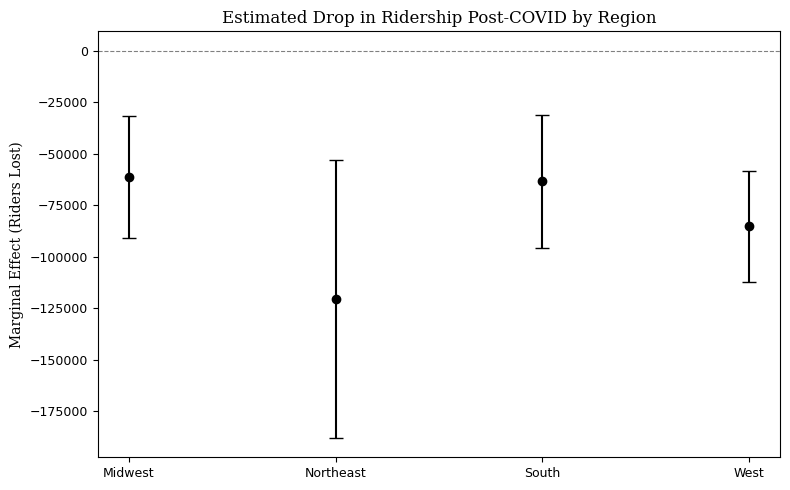

In [14]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt


url = "https://raw.githubusercontent.com/kylejones200/time_series/refs/heads/main/data/amtrak_ridership_time_series_data.csv"
# Load data
df = pd.read_csv(url)
df['Year'] = pd.to_datetime(df['Year'])
df['year'] = df['Year'].dt.year
df['Ridership'] = pd.to_numeric(df['Ridership'], errors='coerce')
df = df.dropna(subset=['Ridership'])

# COVID indicator and time trend
df['post_covid'] = (df['year'] >= 2020).astype(int)
df['t'] = df['year'] - 2005

# Assign region
region_def = {
    "Northeast": ["Connecticut", "Maine", "Massachusetts", "New Hampshire", "Rhode Island", "Vermont", "New Jersey", "New York", "Pennsylvania"],
    "Midwest": ["Indiana", "Illinois", "Michigan", "Ohio", "Wisconsin", "Iowa", "Kansas", "Minnesota", "Missouri", "Nebraska", "North Dakota", "South Dakota"],
    "South": ["Delaware", "Florida", "Georgia", "Maryland", "North Carolina", "South Carolina", "Virginia", "West Virginia",
              "Alabama", "Kentucky", "Mississippi", "Tennessee", "Arkansas", "Louisiana", "Oklahoma", "Texas", "District of Columbia"],
    "West": ["Arizona", "Colorado", "Idaho", "Montana", "Nevada", "New Mexico", "Utah", "Wyoming", "Alaska", "California", "Hawaii", "Oregon", "Washington"]
}

def assign_region(state):
    for region, states in region_def.items():
        if state in states:
            return region
    return "Other"

station_meta = df.drop_duplicates("Station")[["Station", "State"]].copy()
station_meta["Region"] = station_meta["State"].apply(assign_region)
df = df.merge(station_meta[["Station", "Region"]], on="Station", how="left")
df['region'] = df['Region']

# Convert to panel format
df = df.set_index(["Station", "year"]).sort_index()

# Estimate PanelOLS model
model = PanelOLS.from_formula(
    "Ridership ~ post_covid * region + t + EntityEffects",
    data=df,
    drop_absorbed=True
)
res = model.fit(cov_type="clustered", cluster_entity=True)
print(res.summary)

# Extract region-level marginal effects
baseline = res.params["post_covid"]
region_effects = {
    "Midwest": baseline,
    "Northeast": baseline + res.params.get("post_covid:region[T.Northeast]", 0),
    "South": baseline + res.params.get("post_covid:region[T.South]", 0),
    "West": baseline + res.params.get("post_covid:region[T.West]", 0),
}

# Manual 95% CI based on model std errors
ci = {
    "Midwest": (baseline - 1.96 * res.std_errors["post_covid"], baseline + 1.96 * res.std_errors["post_covid"]),
    "Northeast": (region_effects["Northeast"] - 1.96 * res.std_errors["post_covid:region[T.Northeast]"],
                  region_effects["Northeast"] + 1.96 * res.std_errors["post_covid:region[T.Northeast]"]),
    "South": (region_effects["South"] - 1.96 * res.std_errors["post_covid:region[T.South]"],
              region_effects["South"] + 1.96 * res.std_errors["post_covid:region[T.South]"]),
    "West": (region_effects["West"] - 1.96 * res.std_errors["post_covid:region[T.West]"],
             region_effects["West"] + 1.96 * res.std_errors["post_covid:region[T.West]"]),
}

# Plot marginal effects with confidence intervals
regions = list(region_effects.keys())
coefs = [region_effects[r] for r in regions]
lower_err = [abs(ci[r][0] - coefs[i]) for i, r in enumerate(regions)]
upper_err = [abs(ci[r][1] - coefs[i]) for i, r in enumerate(regions)]

plt.figure(figsize=(8, 5))
plt.errorbar(regions, coefs, yerr=[lower_err, upper_err], fmt='o', color='black', capsize=5)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title("Estimated Drop in Ridership Post-COVID by Region", fontname='serif')
plt.ylabel("Marginal Effect (Riders Lost)", fontname='serif')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.savefig("amtrak_panel_region_effects.png", dpi=300)
plt.show()
